In [1]:
import os #Provides functions for interacting with the operating system
import cv2 #OpenCV library for computer vision tasks
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #Adds progress bars to loops
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

## Milestone 1: Data Collection, Exploration, and Preprocessing

In [2]:
data_path = r"C:\Users\sara_\Desktop\jupyter projects\leapGestRecog"
img_size = 128

In [3]:
os.listdir(data_path) #retrieves all subdirectories

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'leapGestRecog']

In [4]:
def get_file_paths_and_labels(base_path):
    file_paths = []
    labels = []
    
    gesture_folders = [
        '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
        '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
    ]
    
    # Map each gesture name to a numeric label
    label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}
    
    # Loop through each subject folder 
    for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)

         # Only continue if it's actually a folder 
        if os.path.isdir(subject_path):  

            # Loop through each gesture folder inside this subject
            for gesture in gesture_folders:
                gesture_path = os.path.join(subject_path, gesture)

                # Check if gesture folder exists 
                if os.path.isdir(gesture_path):  

                    # Loop through each image file inside the gesture folder
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        
                        file_paths.append(img_path)
                         # Store the numeric label for this gesture
                        labels.append(label_map[gesture])
    
    return file_paths, labels, label_map


In [5]:
file_paths, labels, label_map = get_file_paths_and_labels(data_path)

print("Number of images:", len(file_paths))
print("Number of labels:", len(labels))
print("Label map:", label_map)

Number of images: 20000
Number of labels: 20000
Label map: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


# Data Exploration:
## Analyzing, loading and displaying images

In [6]:
def explore_dataset(file_paths, labels, label_map, img_size=128):
    
    # 1. Class Distribution
    label_names = list(label_map.keys())
    counts = [labels.count(idx) for idx in label_map.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(label_names, counts, color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Class Distribution of Gestures")
    plt.xlabel("Gesture Class")
    plt.ylabel("Number of Images")
    plt.show()

     # 2. Display Sample Images
    unique_labels = list(label_map.values())
    label_to_name = {v: k for k, v in label_map.items()}
    
    plt.figure(figsize=(20, 20))
    for idx, label in enumerate(unique_labels):
        # Show up to 6 images for each class
        label_paths = [file_paths[i] for i in range(len(labels)) if labels[i] == label][:6]
        for i, img_path in enumerate(label_paths):
            img = load_img(img_path, color_mode='grayscale', target_size=(img_size, img_size))
            img = img_to_array(img) / 255.0
            plt.subplot(len(unique_labels), 6, idx * 6 + i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(label_to_name[label])
            plt.axis('off')
    plt.show()

    # 3. Image Resolution Check
    sample_img = cv2.imread(file_paths[0], cv2.IMREAD_GRAYSCALE)
    print("Original image resolution:", sample_img.shape)
    print("Resized target resolution:", (img_size, img_size))
    
    # 4. Bias / Imbalance Report
    max_count, min_count = max(counts), min(counts)
    print("\nDataset Balance Check:")
    print(f"Max images in a class: {max_count}")
    print(f"Min images in a class: {min_count}")
    if max_count / min_count > 1.5:
        print("⚠️ Warning: The dataset has imbalance between gesture classes.")
    else:
        print("✅ Dataset is fairly balanced across classes.")

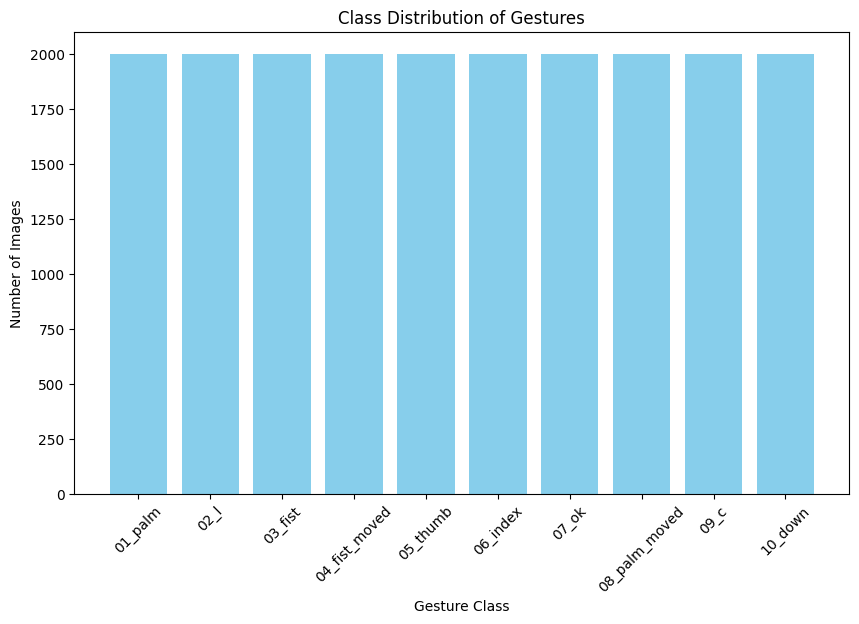

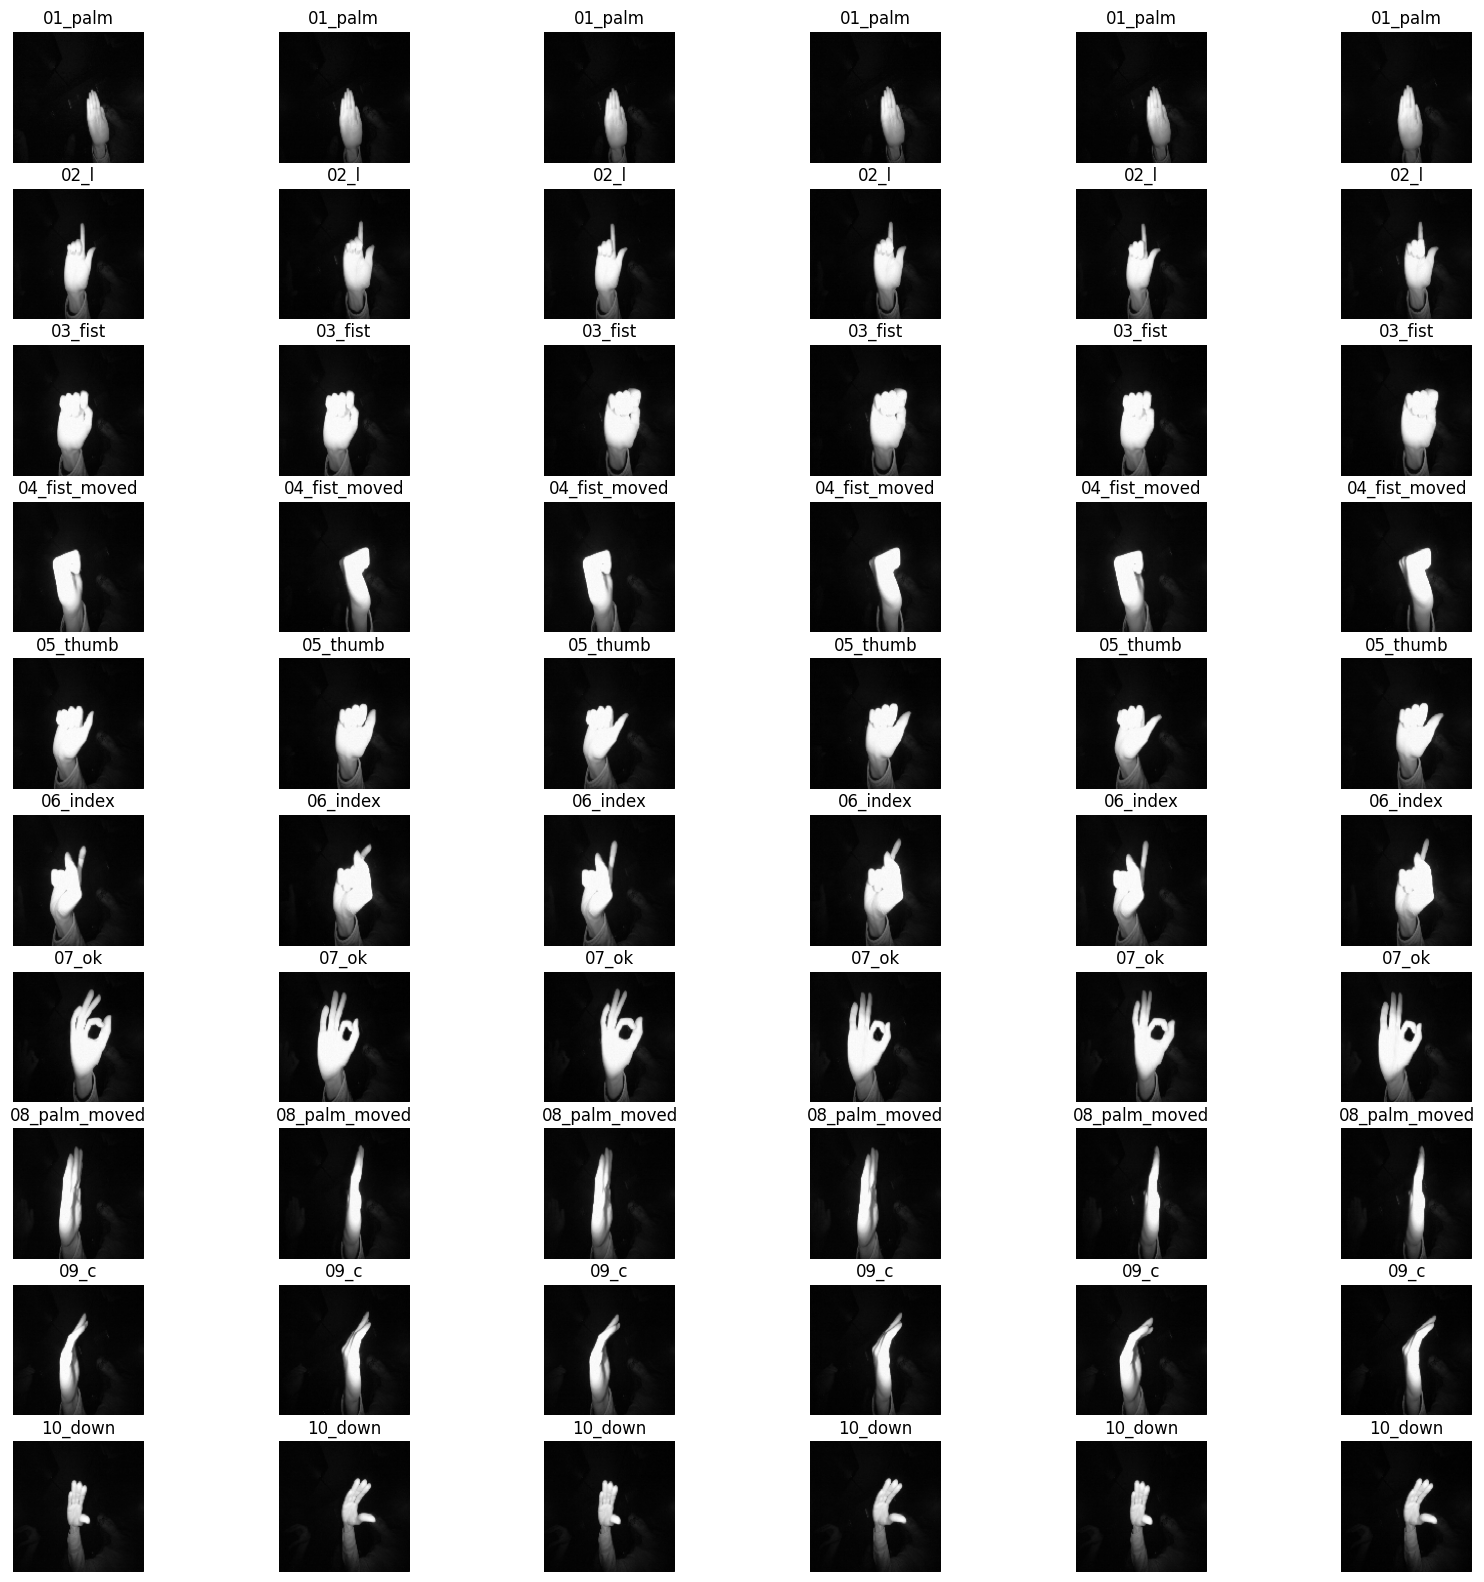

Original image resolution: (240, 640)
Resized target resolution: (128, 128)

Dataset Balance Check:
Max images in a class: 2000
Min images in a class: 2000
✅ Dataset is fairly balanced across classes.


In [7]:
# Define gesture folders and label map
gesture_folders = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]
label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}

explore_dataset(file_paths, labels, label_map, img_size)

# Summary of findings
## 1. Dataset Composition

The dataset used is LeapGestRecog, a hand gesture recognition dataset.

It contains 10 gesture classes:
01_palm, 02_l, 03_fist, 04_fist_moved, 05_thumb, 06_index, 07_ok, 08_palm_moved, 09_c, 10_down.

Each gesture is performed by multiple subjects, giving a balanced dataset.

Total images processed: 20,000 (2000 per class).

## 2. Object Distributions

A class distribution analysis shows exactly 2000 samples per gesture class.

✅ This confirms the dataset is balanced (no class dominates the dataset).

Visualization:

A bar chart confirms equal distribution across classes.

Sample images displayed for each class show clear gesture separation.

## 3. Image Quality

Original resolution: 240 × 640 pixels.

Preprocessed resolution: 128 × 128 pixels (grayscale) for uniformity.

Images are clear, with visible hand gestures.

Backgrounds vary slightly, but do not affect recognition.

## 4. Bias & Imbalance Check

Max images in a class: 2000

Min images in a class: 2000

Ratio (max/min): 1.0 → ✅ Perfect balance.

No dataset bias observed in terms of class representation.

## 5. Environmental Factors

Since this is a hand gesture dataset, external environmental factors like weather or road types (important for autonomous driving datasets) do not apply.

However, some natural variations exist:

Lighting conditions differ slightly across subjects.

Hand position/orientation introduces variability.

These variations improve generalization when training models.

# Data Preprocessing:
## resizing, normalizing and data augmentation

In [8]:
def load_and_process_images(file_paths, target_size):
    processed_images = []
    
    for img_path in tqdm(file_paths, desc="Processing Images"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            #  resize 
            img = cv2.resize(img, (target_size, target_size))
            
            # Normalize to [0, 1]
            img_array = img / 255.0
            
            # Add channel dimension 
            img_array = np.expand_dims(img_array, axis=-1)
            
            processed_images.append(img_array)
    
    return np.array(processed_images)

In [10]:
print("Step 1: Getting file paths and labels")
file_paths, labels, label_map = get_file_paths_and_labels(data_path)

if file_paths:
    print("Step 2: Loading and normalizing all images")
    # Process all images into a NumPy array
    X = load_and_process_images(file_paths, img_size)
    
    # Convert labels list to a NumPy array
    Y = np.array(labels)

    print("\n✅ Data processing complete")
    print(f"Images array shape: {X.shape}")   # e.g. (20000, 128, 128, 1)
    print(f"Labels array shape: {Y.shape}") 

Step 1: Getting file paths and labels
Step 2: Loading and normalizing all images


Processing Images: 100%|███████████████████████████████████████| 20000/20000 [03:38<00:00, 91.58it/s]



✅ Data processing complete
Images array shape: (20000, 128, 128, 1)
Labels array shape: (20000,)


In [11]:
    print("\nData processing complete")
    print(f"Images array shape: {X.shape}")
    print(f"Labels array shape: {Y.shape}")


Data processing complete
Images array shape: (20000, 128, 128, 1)
Labels array shape: (20000,)


Shape of one image: (128, 128, 1)


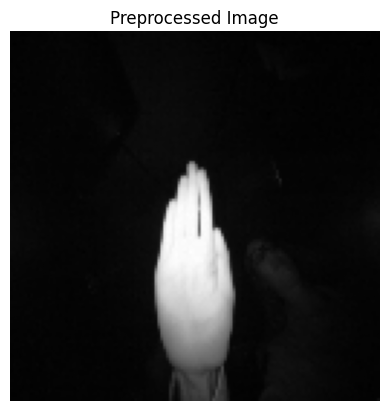

In [12]:
sample_img = X[12]

print("Shape of one image:", sample_img.shape)

plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

# Step 1: First split into Train + Test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Step 2: Split Train into Train + Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Shapes check
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Percentage check
total = len(X)
print(f"\nDataset split summary:")
print(f"Train: {len(X_train)} ({len(X_train)/total:.2%})")
print(f"Validation: {len(X_val)} ({len(X_val)/total:.2%})")
print(f"Test: {len(X_test)} ({len(X_test)/total:.2%})")

Training set: (12800, 128, 128, 1) (12800,)
Validation set: (3200, 128, 128, 1) (3200,)
Test set: (4000, 128, 128, 1) (4000,)

Dataset split summary:
Train: 12800 (64.00%)
Validation: 3200 (16.00%)
Test: 4000 (20.00%)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation only for training set
train_datagen = ImageDataGenerator(
    rotation_range=20,        # random rotation
    width_shift_range=0.1,    # horizontal shift
    height_shift_range=0.1,   # vertical shift
    zoom_range=0.1,           # zoom
    horizontal_flip=True,     # flip horizontally
    fill_mode='nearest'       # fill empty pixels
)

# Validation & Test data → Only normalization (no augmentation!)
test_val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

print("✅ Data augmentation generators are ready!")


✅ Data augmentation generators are ready!


# Preprocessing Summary
## 1. Image Resizing

All images resized from 240×640 → 128×128 pixels (grayscale).

Ensures consistent input size across the dataset.

Lower dimensionality reduces computational cost while retaining gesture details.

## 2. Normalization

Pixel values scaled from [0, 255] → [0, 1].

Normalization improves:

Model convergence speed.

Numerical stability during training.

## 3. Channel Adjustment

Since images are grayscale, a single channel is maintained.

Shape per image after preprocessing: (128, 128, 1).

## 4. Data Augmentation (planned / next step)

To increase dataset robustness and simulate real-world conditions, augmentation techniques will be applied:

Random flipping (horizontal/vertical).

Random rotations.

Random cropping & scaling.

(Optional) Brightness and contrast adjustments to mimic lighting variations.

✅ Preprocessed Dataset Ready

Shape of processed dataset: (20000, 128, 128, 1).

Labels array shape: (20000, ).

Dataset is now clean, normalized, and augmented-ready for model training.